In [1]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series, stationarity_tests
import glob 
import os
from darts.utils.missing_values import fill_missing_values
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import sys, os
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import STL

/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')
df = df.asfreq(freq='T')

In [3]:
df_hourly = df.resample('H').mean().interpolate()

In [4]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df_hourly, value_cols='value')

In [5]:
# Set aside the last 20 percent of ts as a validation series
train, val = series[:-round(len(df_hourly) / 5)], series[-round(len(df_hourly) / 5):]

#### Start outlier detection

In [6]:
outliers_fraction = float(.01)
scaler = StandardScaler()
dataframe_style = series.pd_dataframe() 
np_scaled = scaler.fit_transform(dataframe_style.value.to_numpy().reshape(-1, 1))
data = pd.DataFrame(np_scaled)

#### Train isolation forest

In [7]:
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
dataframe_style['anomaly'] = model.predict(data)

#### Visualization

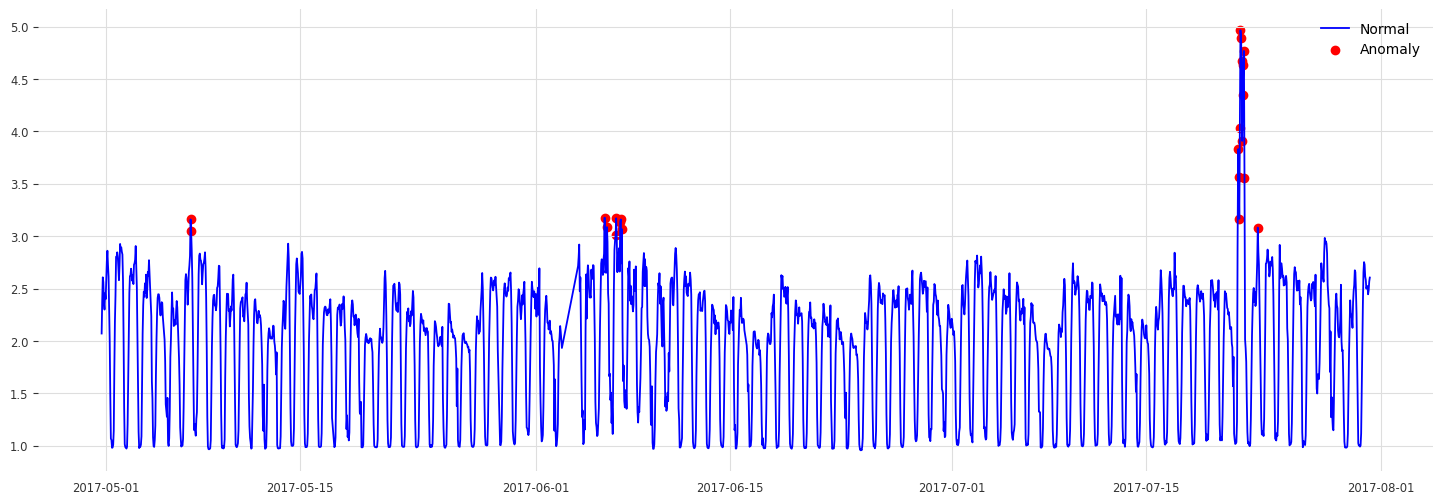

In [8]:
fig, ax = plt.subplots(figsize=(18,6))
a = dataframe_style.loc[dataframe_style['anomaly'] == -1, ['value']] #anomaly
ax.plot(dataframe_style.index, dataframe_style['value'], color='blue', label = 'Normal')
ax.scatter(a.index,a['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();